## 1. Estimation of the Banana distribution

In this notebook, we will show how we can estimate a density $\pi$ given a limited number of samples $\boldsymbol{x}^i \sim \pi \in \mathbb{R}^{N_x}$. We will rely on the adaptive estimation framework developed in Baptista et al. [1].

References: 

[1] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[2] Marzouk, Y., Moselhy, T., Parno, M., & Spantini, A. (2016). Sampling via measure transport: An introduction. Handbook of uncertainty quantification, 1-41.

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions

Load some packages to make nice figures

In [49]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
# PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

### Problem setup

 We start by generating $N_e$ samples from a banana distribution.

In [50]:
Ne = 500 # Number of samples
Nx = 2 # Dimension of the state

# Define the parameters of the banana distribution
μ = 0.0
σ = 2.0
bananicity = 0.3

# Generate the samples
X = sample_banana(Ne, μ = μ, σ = σ, bananicity = bananicity)

2×500 Array{Float64,2}:
 4.12198   1.01935   1.04844  …  -0.555588    -0.187869  -0.0715737
 3.58496  -1.04917  -1.71539      0.00519065  -0.451185  -1.4107

`X` is an ensemble matrix whose columns are the different ensemble members, i.e. $\boldsymbol{X} = 
\left[ \boldsymbol{x}^1, \ldots, \boldsymbol{x}^{N_e} \right]  \in \mathbb{R}^{N_x \times N_e}$.

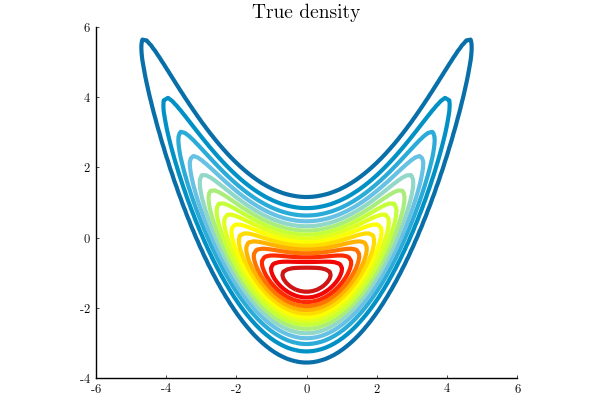

In [51]:
Nlog = 100
logbanana = zeros(Nlog, Nlog)

xrange = range(-6.0; stop = 6.0, length = Nlog)
yrange = range(-4.0; stop = 6.0, length = Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y]; μ = μ, σ = σ, bananicity = bananicity)
    end
end


contour(xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         colorbar = false, grid = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We define an object `S` of  type`HermiteMap`to hold the Knothe-Rosenblatt rearrangement that pushes forward $\pi$ to the reference density, i.e. the standard Gaussian distribution $\rho$.
The default constructor for an `HermiteMap` requires, where $m$ is the maximal order of the Hermite polynomials considered in the expansion, $N_x$ the dimension of the state, $L$ a linear transformation that rescale the samples to get zero mean and unitary standard deviation component-wise, and $C$ an array of $N_x$ `MapComponent`.

In [52]:
m = 30
S = HermiteMap(m, X; diag = true, b = "CstLinProHermite");

The next step is to use the greedy algorithm developed by Baptista et al. (2020) to construct a sparse expansion of the different components of the map $S$. Depending on the accuracy of the amp required. Several options are possible for the optimization: 
* `kfold` uses a k-fold cross validation procedure (the more robust choice)
* `split` splits the set of samples into a training and a testing
* An `Int64` to determine the maximum number of features for each component $s^k$ of the map $S$
* `nothing` to simply optimize the existing coefficients in the basis expansion

In [53]:
@time optimize(S, X, "kfold"; withqr = true)

  6.031841 seconds (3.11 M allocations: 8.651 GiB, 5.19% gc time)


Hermite map of dimension 2:
Hermite map component of dimension 1 with Nψ = 6 active features
Hermite map component of dimension 2 with Nψ = 20 active features


The map $S$ is an approximation of the pushforward of the target density $\pi$, to the standard Gaussian density $\rho$.

We can access the different components of the map $S$ as follows:

In [54]:
S[1]

Hermite map component of dimension 1 with Nψ = 6 active features


In [55]:
S[2]

Hermite map component of dimension 2 with Nψ = 20 active features


We can access the coefficients of the expansion for each map component with `getcoeff`.

In [56]:
getcoeff(S[2])

20-element Array{Float64,1}:
  33.40887209771726
 -36.70841961789348
   6.289777692016939
 -19.148670218139156
   0.9063421653425254
  -3.9857677223426506
  -1.0180249510368595
  -1.1531717337256375
  -3.590133809920639
   3.0312251567226602
  -1.3268965072003942
  -2.810089488484782
 -24.607297942379144
  -3.365598963602197
 -26.53897922474047
   0.7598329274009462
   0.6853249994186028
  -0.5227279827178749
  -1.760783830068723
  -9.671548182151916

In [57]:
S[2].I.f.idx

20×2 Array{Int64,2}:
 1   0
 0   1
 0   2
 0   3
 0   4
 0   5
 2   0
 3   0
 0   6
 0   7
 0   8
 4   0
 5   0
 6   0
 7   0
 0   9
 0  10
 0  11
 8   0
 9   0

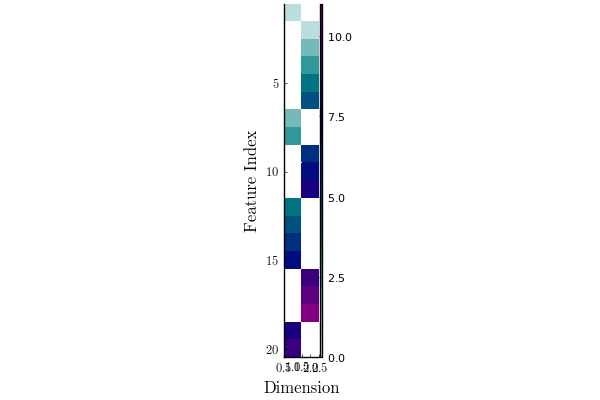

In [58]:
plot(S[2].I.f)

`getidx` can be used to obtain the active features of the different map components. The number of columns is the number of dimensions. Each line correspond to a multi-index for the different components 

In [59]:
getidx(S[1])

6×1 Array{Int64,2}:
 1
 2
 3
 4
 5
 6

Using `PlotRecipes.jl`, we plot the number of occurences of each variable (*columns*) in each map component (*rows*).

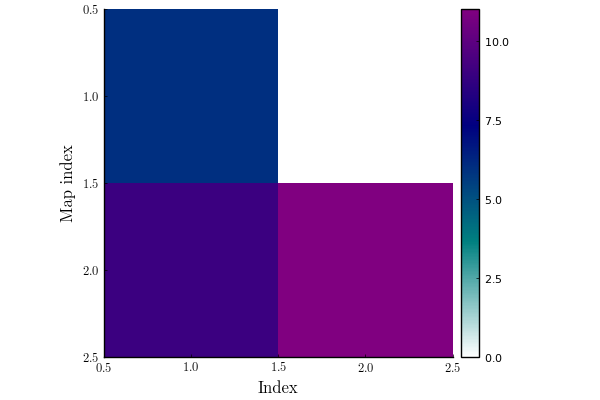

In [60]:
plot(S)

By setting `degree = true`, we plot maximum multi-index of the features identified for each variable (*columns*) in each map component (*rows*)

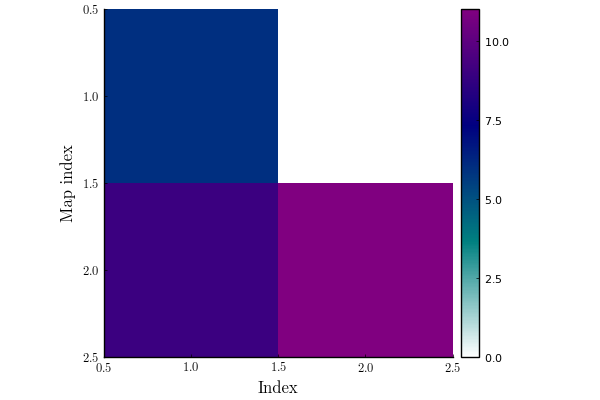

In [61]:
plot(S; degree = true)

  We can now compare the log-density of the true Banana density with the approximated one.

Let's create a grid and evaluate the logpdf the densities

In [62]:
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)

for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana_approx[i,j] = log_pdf(S, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

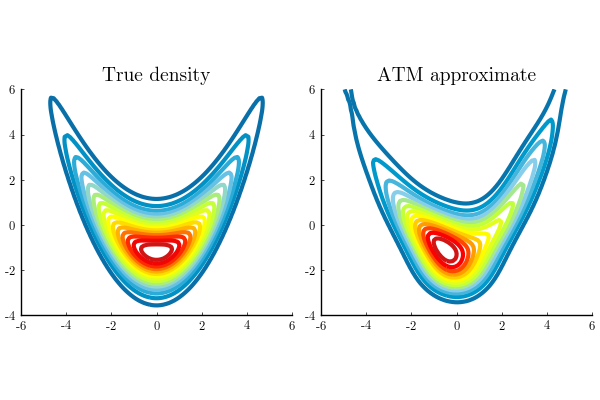

In [63]:
plt = plot(layout = grid(1, 2), colorbar = false, grid = false)
contour!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1,
         title = "True density",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

contour!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1,
         title = "ATM approximate",
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (-Inf, Inf), linewidth = 3)

We can overlap the estimated density with the samples

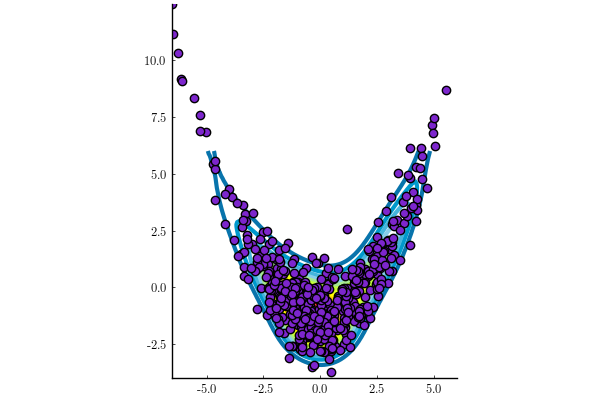

In [64]:
contour(xrange, yrange, exp.(logbanana_approx)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(X[1,:], X[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6)

By definition, the map $S$ pushes forward the samples $\boldsymbol{x}^i$ to the standard normal distribution $\rho$ of $\mathbb{R}^2$, denoted $\boldsymbol{S}_{\sharp} \pi = \rho$,  i.e. $\boldsymbol{x}^i \sim \pi \Rightarrow{} \boldsymbol{S}(\boldsymbol{x}^i) \sim \rho$

In [65]:
SpushX = evaluate(S, X)

2×500 Array{Float64,2}:
  1.92258    0.539882    0.55197   …  -0.240434  -0.0362032   0.0260337
 -0.498787  -0.0430779  -0.696838      1.11291    0.769429   -0.12932

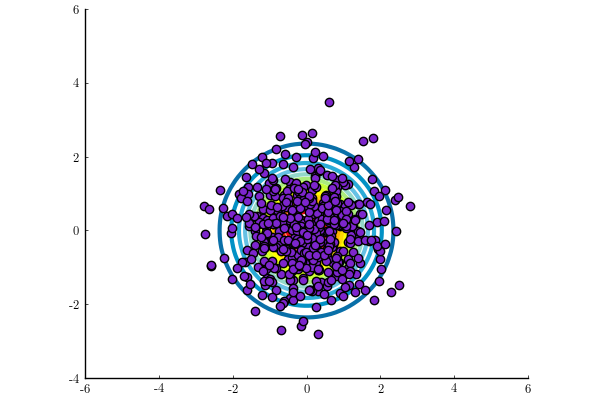

In [66]:
contour(xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (-Inf, Inf), ylim = (-Inf, Inf), linewidth = 3)
scatter!(SpushX[1,:], SpushX[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6)

We can compute the statistics of the pushed samples

In [67]:
mean(SpushX; dims = 2)[:,1] # close to zero

2-element Array{Float64,1}:
 -0.0006096135811719919
 -5.793168358846068e-5

In [68]:
cov(SpushX; dims = 2) # close to the identity matrix 

2×2 Array{Float64,2}:
 0.996161  4.298e-5
 4.298e-5  0.991337

We can use the map $\boldsymbol{S}$ to generate new samples from the target density $\pi$. The map $\boldsymbol{S}$ pulls back  samples $\boldsymbol{z}^i$ of the standard normal distribution $\rho$ to the target density $\pi$, denoted $\boldsymbol{S}^{\sharp} \rho = \pi$, i.e. $\boldsymbol{z}^i \sim \rho \Rightarrow{} \boldsymbol{S}^{-1}(\boldsymbol{z}^i) \sim \pi$.

In [69]:
Znew = randn(Nx, Ne)
Xnew = zeros(Nx, Ne);

We use the in-place routine `inverse` to solve the triangular system $\boldsymbol{S}(\boldsymbol{x}^i) = \boldsymbol{z}^i$ for $\boldsymbol{x}^i \in \mathbb{R}^{N_x}$ for the different samples. From the lower triangular structure of $\boldsymbol{S}$, this inversion reduces to a sequence of one dimensional root finding problems Marzouk et al. [2].

In [70]:
inverse!(Xnew, copy(Znew), S)

2×500 Array{Float64,2}:
 -0.277914  -0.67239  -0.688564  -1.452    …  -2.85429   3.58754  -0.84412
 -0.401589  -1.18018  -1.03402   -1.65541      0.486166  3.46476  -1.70824

In [71]:
evaluate(S, Xnew)-Znew

2×500 Array{Float64,2}:
  0.0           0.0           0.0          …   0.0          0.0   0.0
 -1.55431e-15  -2.01228e-15  -9.88792e-16     -1.11022e-15  0.0  -1.88738e-15

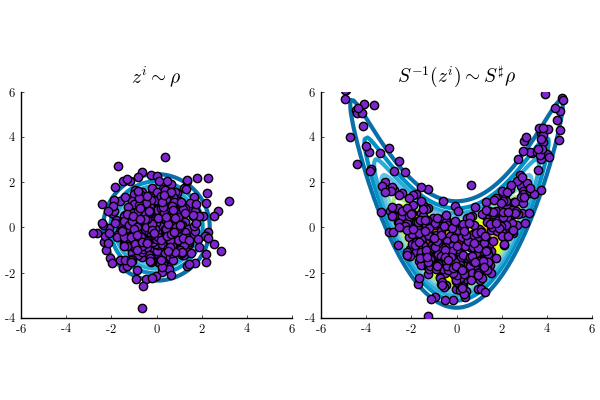

In [72]:
plt = plot(layout = grid(1, 2))

contour!(plt[1,1], xrange, yrange, exp.(lognormal)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,1], Znew[1,:], Znew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6, 
         title = L"z^i \sim \rho")

contour!(plt[1,2], xrange, yrange, exp.(logbanana)', ratio = 1, colorbar = false,
         color = cgrad([:dodgerblue4, :deepskyblue3, :skyblue, :olivedrab1, :yellow, :orange, :red, :firebrick]),
         xlim = (xrange[1], xrange[end]), ylim = (yrange[1], yrange[end]), linewidth = 3)
scatter!(plt[1,2], Xnew[1,:], Xnew[2,:]; legend = false, color = :purple3, ratio = 1, markersize = 6,
            title = L"S^{-1}(z^i) \sim S^{\sharp}\rho")